# 2 Modelling without Text Data

- Author: Jason Truong
- Last Modified: September 19, 2022
- Email: Jasontruong19@gmail.com

# Table of Contents

1. **[Introduction](#1Introduction)**  
2. **[Preliminary Data Setup](#2Preliminary)**  
    2.1. [Set up Train/Test Split](#2.1traintest)  
    2.2. [Scale data](#2.2scaledata)  
3. **[Logistic Regression](#3logistic)**  
    3.1 [Logistic model](#3.1logitmodel)  
    3.2 [Logistic Hyperparameter tuning](#3.2logit_tuning)  
4. **[Decision Tree](#4decisiontree)**  
    4.1 [Decision Tree model](#4.1dtmodel)  
    4.2 [Decision Tree Hyperparameter tuning](#4.2dt_tuning)  
5. **[XGBoost](#5xgboost)**  
    5.1 [XGBoost model](#5.1xgboost_model)  
    5.2 [XGBoost Hyperparameter tuning](#5.2_xgboost_tuning)  
6. **[Summary](#6summary)**


# 1. Introduction<a class ='anchor' id='1Introduction'></a>

With the preprocessed data from the first notebook, (Preprocessing and EDA) the data can now be inputed into different models. This notebook use two classification models, logisitic regression and decision tree models as well as an ensemble method, XGBoost to model the preprocessed data. The objective is to determine how well the models will perform using only the numeric features (excluding the text portion of the review) to predict the the sentiment of the review.

# 2. Preliminary Data Setup<a class ='anchor' id='2Preliminary'></a>

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split

Load in the dataset

In [40]:
review_df = pd.read_json('numeric_review.json')

# Check the data that is loaded in
review_df.head()

,reviewScore,verified,vote,reviewDay,reviewMonth,reviewYear,style_Amazon Video,style_Blu-ray,style_DVD,style_Other,style_VHS Tape,reviewer_ID,itemID
0,5,1,4,2,11,2002,0,0,1,0,0,0,0
1,5,0,3,28,1,2002,0,0,1,0,0,1,0
2,5,0,2,12,12,2001,0,0,1,0,0,2,0
3,3,0,31,11,12,2001,0,0,0,0,1,3,0
4,4,0,62,19,10,2001,0,0,1,0,0,4,0


The review score will be split into positive (value of 1) and negative (value of 0) for sentiment analysis. Anything below 4 will be mapped to 0 and anything above and including 4 will be mapped to 1

In [43]:
review_df['reviewClass'] = np.where(review_df['reviewScore']>=4,1,0)

# Check results
review_df['reviewClass'].value_counts()

1    1418290
0     279963
Name: reviewClass, dtype: int64

The `reviewClass` coloumn now only has two classes. The proportion of positive and negative reviews can be determined.

In [46]:
(review_df['reviewClass'].value_counts()/review_df.shape[0])*100

1    83.514647
0    16.485353
Name: reviewClass, dtype: float64

83.5% of the reviews have a positive sentiment. Now that the reviews have been split into positive and negative sentiments, a train/test split can be made. The baseline accuracy will be taken as 83.5% since this is the score if the prediction for the reviews are all taken to be positive.

## 2.1 Setup train and test split<a class ='anchor' id='2.1traintest'></a>

In [6]:
# The prediction is for the reviewScore
X = review_df.drop(columns = ['reviewScore','reviewClass'])
y = review_df['reviewClass']

# Create the train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, stratify = y)

**Note: A validation set is not made because the hyperparameter tuning will be done in a pipeline with a 5-fold cross validation. Thus, a validation set is not needed.**

## 2.2 Scale the data<a class ='anchor' id='2.2scaledata'></a>

Since many of the columns are in their own scale, a standard scaler will be used to normalize the data.

In [7]:
from sklearn.preprocessing import StandardScaler

# Instantiate Scaler
ss = StandardScaler()

# Fit the Scaler
ss.fit(X_train)

# Transform
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [ ]:
# Check the transformed values
X_train_ss

The data in both the training and test set has been normalized so now they can be inputed into the different models.

# 3. Logistic Regression<a class ='anchor' id='3logistic'></a>

A simple logisitic regression will be used to start things off and see how well the model fits the data.

## 3.1 Logistic Model<a class ='anchor' id='3.1logitmodel'></a>

In [8]:
from sklearn.linear_model import LogisticRegression

# Instantiate
logreg = LogisticRegression(C = 1)

# Fit the model
logreg.fit(X_train_ss,y_train)

# Score the model
print(f"Train score: {logreg.score(X_train_ss,y_train)}")
print(f"Test score: {logreg.score(X_test_ss,y_test)}")

Train score: 0.8349769841774561
Test score: 0.835004852036442


The train and test scores are very close to one another which shows that the model may be performing well. Since the review dataset had 83.5% positive reviews, the logisitic regression model is not performing better than randomly guessing everything as positive. The conclusion that can be drawn from this is that the data without text features does not help predict the sentiment of the review in any way.  

The above model can be saved so this notebook can be ran without fitting the model again.

In [9]:
# Save the above model
# pickle.dump(logreg, open('nb2models/log_reg_model.pickle','wb'))

In [10]:
# Load the saved model
logreg = pickle.load(open('nb2models/log_reg_model.pickle','rb'))

To further analyze these results, the precision and recall scores can be determined for the logistic model.

In [11]:
from sklearn.metrics import classification_report

# Get the model predictions.
y_pred = logreg.predict(X_test_ss)

# Get the classification report for the model
c_report_logreg = classification_report(y_test,y_pred)

print(c_report_logreg)

              precision    recall  f1-score   support

           0       0.21      0.00      0.00     69991
           1       0.84      1.00      0.91    354573

    accuracy                           0.84    424564
   macro avg       0.52      0.50      0.46    424564
weighted avg       0.73      0.84      0.76    424564



The precision and recall for predicting positive reviews is great but the revall and precision for predicting negative reviews is terrible. This can be due to the imbalance in the dataset and the features not having much predictive power for predicting the sentiment. A confusion matrix can be plotted to see now many reviews were predicted correctly.

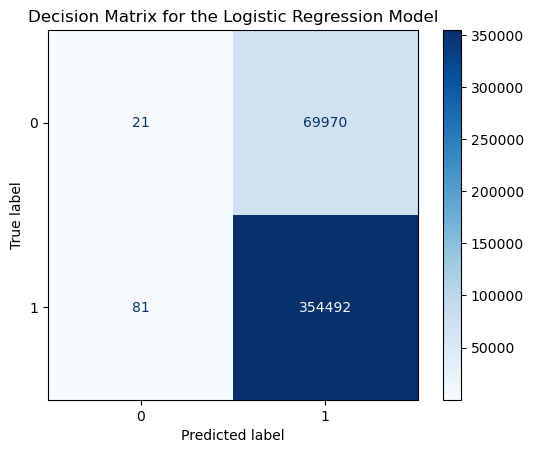

In [55]:
from sklearn.metrics import plot_confusion_matrix

# Plot the decision matrix
plot_confusion_matrix(logreg, X_test_ss, y_test, cmap = 'Blues', values_format ='')

# Add labels to the plot
plt.title('Decision Matrix for the Logistic Regression Model')
plt.show()

The above decision matrix shows that the model is unable to generalize the data well for predicting negative reviews.

**Create a function to run the classification report and confusion matrix**

In [56]:
def class_report(model,X_test_ss,y_test):
    '''
    This function takes in the machine learning model as well as the test data and outputs a classification report.
    
    '''
    
    # Get the model predictions.
    y_pred = model.predict(X_test_ss)

    # Get the classification report for the model
    c_report = classification_report(y_test,y_pred)
    
    return print(c_report)

In [57]:
def conf_matrix(model,X_test_ss,y_test,model_type):
    '''
    This function takes in the machine learning model, test data and the model name. 
    The output is a decision matrix for the model
    
    '''
    
    # Plot the decision matrix
    plot_confusion_matrix(model, X_test_ss, y_test, cmap = 'Blues', values_format ='')

    # Add labels to the plot
    plt.title(f'Decision Matrix for the {model_type} model')
    plt.show()

Now that there is a function to output the classification report and decision matrix, it will be used for in the rest of this notebook for the other models.

## 3.2 Logistic Hyperparameter Tuning <a class ='anchor' id='3.2logit_tuning'></a>

**Create a ML Pipelines to determine the best hyper parameters** 

Machine learning pipelines are a useful tool to help test multiple parameters at once and they also help ensure that there is no data leakage to the test set.

In [ ]:
# Set up caching for the pipeline.
from tempfile import mkdtemp
cachedir = mkdtemp()

First, the pipeline structure will be set up.

In [14]:
from sklearn.pipeline import Pipeline

# Instantiate pipeline settings
estimators = [('normalize', StandardScaler()),
             ('model', LogisticRegression())]

# Instantiate pipeline model
pipeline_model = Pipeline(estimators, memory = cachedir)

The pipeline will include different parameters for the logistic regression as well as a scaling function to determine if scaling makes a difference for the model performance. 

In [15]:
from sklearn.model_selection import GridSearchCV

# Set up parameters for the pipeline
logit_param_grid = [
    
    {'normalize': [None, StandardScaler()],
     'model__solver': ['lbfgs', 'liblinear'],
     'model__penalty': ['l2'],
     'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
]

# Instantiate grid search
logit_gsearch = GridSearchCV(estimator=pipeline_model, param_grid=logit_param_grid, cv = 5, verbose = 1, n_jobs = -1)

Now that the model is created, we can fit the grid search with a 5 fold cross validation.

In [16]:
fit_logit_grid = logit_gsearch.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [17]:
fit_logit_grid.best_params_

{'model__C': 0.0001,
 'model__penalty': 'l2',
 'model__solver': 'lbfgs',
 'normalize': None}

The best model with the different parameters are shown above.

In [60]:
# Score the model
print(f"Train score: {logit_gsearch.score(X_train,y_train)}")
print(f"Test score: {logit_gsearch.score(X_test,y_test)}")


Train score: 0.8351465703166158
Test score: 0.8351461734862118


The best logistic regression model did not improve the train or test score at all.

The above model can be saved so this notebook can be ran without fitting the model again.

In [20]:
# Save the above model
pickle.dump(logit_gsearch, open('nb2models/logit_optimized_model.pickle','wb'))

In [21]:
# Load the saved model
# logit_gsearch = pickle.load(open('nb2models/logit_optimized_model.pickle','rb'))

The classification report and decision matrix can be created to see if the hyperparameter tuning affected the original logistic regression results.

In [22]:
# Determine the precision and recall of the model
class_report(logit_gsearch,X_test_ss,y_test)

              precision    recall  f1-score   support

           0       0.22      0.40      0.28     69991
           1       0.86      0.71      0.78    354573

    accuracy                           0.66    424564
   macro avg       0.54      0.56      0.53    424564
weighted avg       0.75      0.66      0.70    424564



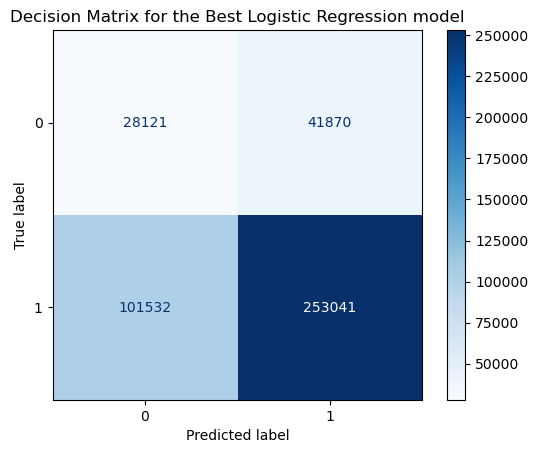

In [61]:
# Plot the decision matrix
conf_matrix(logit_gsearch,X_test_ss,y_test, 'Best Logistic Regression')

The tuned logisitic regression model is able to predict negative reviews better as the recall for negative predictions increased significantly from 0 to 40%. Although the model can better predict negative reviews, the recall for the positive predictions dopped from 100% to 71%. This hyperparameter tuning made the model predict more negative reviews which is a good step towards better predicting negative reviews. The downside is that the model predicts less positive reviews.

# 4. Decision Tree<a class ='anchor' id='4decisiontree'></a>

The decision tree model can also be used to fit the data to determine if the numeric features without the text data affect the sentiment prediction.

## 4.1 Decision Tree Model<a class ='anchor' id='4.1dtmodel'></a>

A simple decision tree model will be fit to the data.

In [23]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate
decisiontree_model = DecisionTreeClassifier()

# Fit the model
decisiontree_model.fit(X_train_ss,y_train)

# Score the model
print(f"Train score: {decisiontree_model.score(X_train_ss,y_train)}")
print(f"Test score: {decisiontree_model.score(X_test_ss,y_test)}")

Train score: 0.9999395456818737
Test score: 0.7623444286373786


The training score is almost at 1, thus the model is overfitting. This is expected because the max depth wasn't specified in the model so the tree expanded to as many leaves as possible. The test score is actually lower than the baseline so this current model performs worst than if we guessed that all the reviews are positive.

The above model can be saved so this notebook can be ran without fitting the model again.

In [24]:
# Save the above model
pickle.dump(decisiontree_model, open('nb2models/dt_model.pickle','wb'))

In [25]:
# Load the saved model
#decisiontree_model = pickle.load(open('nb2models/dt_model.pickle','rb'))

To further analyze these results, the precision and recall scores can be determined for the decision tree model.

In [63]:
# Determine the precision and recall of the model

class_report(decisiontree_model,X_test_ss,y_test)

              precision    recall  f1-score   support

           0       0.29      0.31      0.30     69991
           1       0.86      0.85      0.86    354573

    accuracy                           0.76    424564
   macro avg       0.58      0.58      0.58    424564
weighted avg       0.77      0.76      0.77    424564



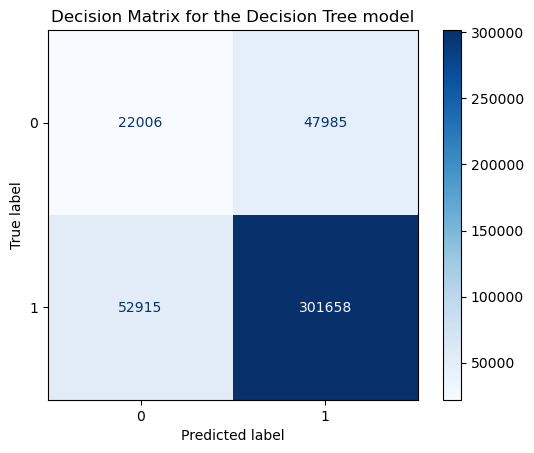

In [64]:
# Plot the decision matrix
conf_matrix(decisiontree_model,X_test_ss,y_test, 'Decision Tree')

Although the decision tree accuracy score is lower than the logistic regression accuracy score

## 4.2 Decision Tree Hyperparameter Tuning<a class ='anchor' id='4.2dt_tuning'></a>

First, the pipeline structure will be set up.

In [27]:
# Instantiate pipeline settings
tree_estimators = [('model', DecisionTreeClassifier())]

# Instantiate pipeline model
tree_pipeline_model = Pipeline(tree_estimators, memory = cachedir)

In [28]:
# Set up parameters for the pipeline
tree_param_grid = [
    
    {'model__max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
     'model__min_samples_leaf': [2, 4, 6, 8, 10]}
]

# Instantiate grid search
tree_gsearch = GridSearchCV(estimator=tree_pipeline_model, param_grid=tree_param_grid, cv = 5, verbose = 1, n_jobs = -1)

Fit the grid search with a 5 fold cross validation.

In [29]:
fit_tree_grid = tree_gsearch.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [30]:
# Determine the best decision tree hyper parameters
fit_tree_grid.best_params_

{'model__max_depth': 10, 'model__min_samples_leaf': 4}

In [72]:
print(f'Decision Tree model train set accuracy: {round(tree_gsearch.score(X_train,y_train),4)}%')
print(f'Decision Tree model train set accuracy: {round(tree_gsearch.score(X_test,y_test),4)}%')

Decision Tree model train set accuracy: 0.8388%
Decision Tree model train set accuracy: 0.8374%


The best parameters for the decision tree did not increase the baseline accuracies by a significant amount.

In [32]:
# Save the above model
pickle.dump(fit_tree_grid, open('nb2models/dt_optimized_model.pickle','wb'))

In [33]:
# Load the saved model
# fit_tree_grid = pickle.load(open('nb2models/dt_optimized_model.pickle','rb'))

The classification report and decision matrix can be created to see if the hyperparameter tuning affected the original logistic regression results.

In [34]:
# Determine the precision and recall of the model

class_report(fit_tree_grid,X_test,y_test)

              precision    recall  f1-score   support

           0       0.28      0.00      0.01     69991
           1       0.84      1.00      0.91    354573

    accuracy                           0.83    424564
   macro avg       0.56      0.50      0.46    424564
weighted avg       0.74      0.83      0.76    424564



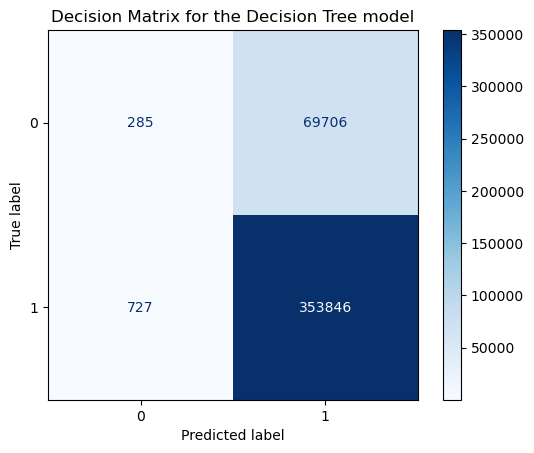

In [65]:
# Plot the decision matrix
conf_matrix(fit_tree_grid,X_test_ss,y_test, 'Decision Tree')

The precision and recall for the best decision tree model is performing just as poorly as the logistic regression model. This is most likely due to the numeric features not having any predicitve power towards the sentiment prediction.

# 5. XGBoost<a class ='anchor' id='5xgboost'></a>

An ensemble method can be experimented with to determine if the data can be fitted well. This section will use XGBoost to fit the model because XGboost is effective in fitting large scale datasets.

## 5.1 XGboost Model<a class ='anchor' id='5.1xgboost_model'></a>

The XGboost model with no hyper parameter tuning will be ran to fit the data.

In [35]:
from xgboost import XGBClassifier

# Instantiate model
XGB_model = XGBClassifier()

# Fit model
XGB_model.fit(X_train_ss,y_train)

# Score the model
print(f"Train score: {XGB_model.score(X_train_ss,y_train)}")
print(f"Test score: {XGB_model.score(X_test_ss,y_test)}")

C:\Users\jason\anaconda3\envs\mlenv\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Train score: 0.842950673202014
Test score: 0.841185310106368


The train and test scores are very slightly better than the baseline accuracy of 0.835. The XGBoost model is the best model to predict the sentiment of the reviews.

The above model can be saved so this notebook can be ran without fitting the model again.

In [36]:
# Save the above model
pickle.dump(XGB_model, open('nb2models/xgb_model.pickle','wb'))

In [37]:
# Load the saved model
# XGB_model = pickle.load(open('nb2models/xgb_model.pickle','rb'))

To further analyze these results, the precision and recall scores can be determined for the XGBoost model.

In [38]:
# Determine the precision and recall of the model

class_report(XGB_model,X_test_ss,y_test)

              precision    recall  f1-score   support

           0       0.66      0.07      0.13     69991
           1       0.84      0.99      0.91    354573

    accuracy                           0.84    424564
   macro avg       0.75      0.53      0.52    424564
weighted avg       0.81      0.84      0.78    424564



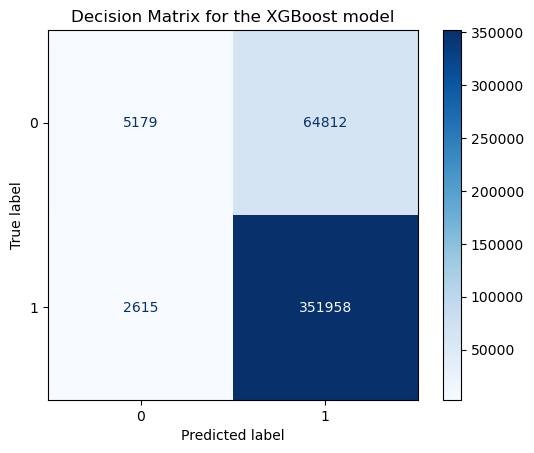

In [73]:
# Plot the decision matrix
conf_matrix(XGB_model,X_test_ss,y_test, 'XGBoost')

**Due to time constraints, the XGBoost hyperparameter tuning will not be analyzed for now and will be future work**

# 6. Summary<a class ='anchor' id='6summary'></a>

None of the models are able to predict the sentiment well without the text data. Since the data is highly unbalanced, the models are unable to predict the negative reviews effectively.